# Plotting Normals and Anomalies for `Daymet` Data

##### Keywords:  ORNL DAAC, Daymet, weather estimates, Anomalies, Normals, THREDDS, OPeNDAP, Earthdata, `pydap`

## Overview
In this tutorial, we will explore using the `pydap` package to plot `Daymet` data. Specifically, we will calculate anomalies and normals for a weather estimate such as `tmin`, `tmax`, and `prcp`. To learn more about how to use Jupyter Notebooks, check out this [`YouTube` video](https://www.youtube.com/watch?v=JImOfVHQtYc).

![](output.png)

## Source Data
A spatial subset of the North American Daymet dataset daily data; https://daymet.ornl.gov . In this example, we will access the data from the ORNL DAAC's THREDDS server: https://thredds.daac.ornl.gov/thredds/catalog/daymet-v3-agg-tiles/catalog.html

## Prerequisites:
Python 2.7 or greater. Python modules: `pydap`, `basemap`, `matplotlib`

## Procedure

### 1. Import Dependencies
Let's import all the libraries that we will need. ***If the following cell does not execute correctly***, then you need to install any package that is missing as seen in the error message. For example, you may need to install `basemap` or `pydap`. Depending upon which `Python` environment you are using, you can install these packages with commands such as:

+ pip install pydap

or 

+ conda install pydap

Now, run the following cell.

In [1]:
from mpl_toolkits.basemap import Basemap # plotting data on map
from IPython.display import display      # iPython Widgets
from pydap.client import open_url        # pydap package
import matplotlib.pyplot as plt          # base plotting package
import ipywidgets as widgets             # iPython Widgets
import datetime as datetime              # datetime package
import numpy as np                       # numerical processing
import warnings                          # supress warnings
import time


warnings.filterwarnings('ignore')
%matplotlib inline

### 2. What are Normals and Anomalies?
It is important to note that both normals and anomalies can be calculated at different spacial resolutions. For the following definitions, let's assume we are interested in a single lat-lon location. Later on in the notebook, we will be calculating normals and anomalies for a `tile` of Daymet data ($2$ x $2$ degree space).
#### Normals
As defined by the [`NOAA`](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/climate-normals/1981-2010-normals-data), a climate **normal** of a particular weather estimate (such as minimum temperature) is a 30 year average from 1981 to 2010. *For example*, the April normal for minimum temperature would be calculated as follows:

$$Normal=\frac{1}{30} \sum_{i=1981}^{2010} \left( \frac{1}{30} \sum_{j=1}^{30} tmin_{i,j}\right)$$

where $i$ represents the year and $j$ is the day in April. For example, $tmin_{ 1990,22}$ is the specific $tmin$ value for April 22, 1990. The $\frac{1}{30}$ factors come from computing averages. ***Note that there are more comprehensive formulas for calculating Normals; this is the simplest form of using variable means only.***

<br>
Normals can be calculated for monthly averages (as seen above), yearly averages, or even seasonal averages.  A yearly normal is simply all the data for a specific variable average over 30 years (what we will do in this Jupyter Notebook). As long as the same time range is selected for each year, a normal can be calculated.

#### Anomalies
Anomalies are the deviations from the Normal over a specified time range that is within the time range of the Normal. An example of this will be shown in the notebook.

### 3. Accesing THREDDS Server
The `Daymet` data we will use is hosted on a `THREDDS` server. To learn more about accessing `Daymet` data from a `THREDDS` server, click [here](https://daymet.ornl.gov/dataaccess.html#THREDDS).


The server we will be working with in this notebook can be found [here](https://thredds.daac.ornl.gov/thredds/catalog/daymet-v3-agg-tiles/catalog.html). We will be using the tiled data.  In this notebook, let's look at tile id `11371`. This tile is centered at 
* lat = 37°
* lon = -119°

<br> 
In order to understand the layout of this server, let's navigate the directory as follows:

1. Click on this [link](https://thredds.daac.ornl.gov/thredds/catalog/daymet-v3-agg-tiles/catalog.html)
2. Enter the directory: [`11371/`](https://thredds.daac.ornl.gov/thredds/catalog/daymet-v3-agg-tiles/11371/catalog.html)
3. Click on [`tmin.ncml`](https://thredds.daac.ornl.gov/thredds/catalog/daymet-v3-agg-tiles/11371/catalog.html?dataset=daymet-v3-agg-tiles/11371/tmin.ncml)

<br>
From here, you can see that access to the data is available through an OpenDAP data access form. Click on this [`OpenDAP link`](https://thredds.daac.ornl.gov/thredds/dodsC/daymet-v3-agg-tiles/11371/tmin.ncml.html)

#### OPeNDAP Dataset Access Form
On this page, you will notice a data URL. In this case, it should be: <br>
`https://thredds.daac.ornl.gov/thredds/dodsC/daymet-v3-agg-tiles/11371/tmin.ncml`

<br>
The `pydap` package will use the URL to pull data into this Jupyter Notebook. <br>
If we wanted the data for a different tile, simply replace the tile in the URL with whichever tile you are interested in plotting. [The following image](https://daymet.ornl.gov/files/images/v3/Tiles_DaymetV3.png) shows each tile number on the `Daymet` grid if you are interested in a specific tile. 

![title](https://daymet.ornl.gov/files/images/v3/Tiles_DaymetV3.png)

### 4. Selecting the variable

First, we need to select a variable to analyze.
Run the following cell and select a variable that you would like to use to calculate the Normal.

In [2]:
w_group = widgets.Dropdown(options=["tmin", "tmax", "prcp"], description="Select a Variable")
display(w_group)
curr_var = "tmin"
def on_change(change):
    global curr_var
    if change['name'] == 'value':
        curr_var = w_group.value
w_group.observe(on_change)

Run the following cell to make sure the appropriate variable will be used.

In [3]:
print('We are going to be working with:', curr_var)

We are going to be working with: tmin


### 5. Calculate Normal for Selected Variable at Tile: 11371
Now, let's go through the steps of calculating the yearly normal for this variable and tile. This will require use of the `pydap` package.

#### First, an understanding of the data
The data we are working with is aggregated tile data. We are going to receive all of the data over all years for the tile and variable selected. That means the data has the following dimensions: (num_days, y_dim, x_dim).

The total number of days (num_days) for the Daymet collection from 1980 to 2016 is 365 * 37 years = 13505 days (Daymet excludes one day for each leap year). The y_dim and x_dim is simply the grid layout for that tile. Each tile will have a slightly different grid size, but each tile will have the same number of days: 13505 days.

#### Subsetting the Data
We can subset the data using the num_days dimension. For example, if we wanted the data for only 1980, we would subset `[0..364]`. We need to get the data for the years 1981 through 2010 in order to calculate the normal. So, let's find the indices that match these years.

The following code block will produce a dictionary of indices for each date in the Daymet collection.

In [4]:
index = -1
dates = {}
d =  datetime.datetime(1980,1,1)
delta = datetime.timedelta(days=1)
end_date = datetime.datetime(2016,12,31)
while d <= end_date:
    index += 1
    if d.month == 12:
        if d.day == 31:
            if d.year % 4 == 0:
                index -= 1
    dates[d.strftime("%m-%d-%Y")] = index
    d += delta
# example
print(dates["12-31-1980"])

364


Now, let's get the indices for years 1981 through 2010. Each key to the dates dictionary is a day of the year formated as <br> `MM-DD-YYYY`.

In [5]:
start_index = dates["01-01-1981"]
end_index   = dates["01-01-2011"]
print(start_index, end_index)

365 11315


Recall that subsetting arrays in `Python` is exclusive for the end index so we had to use January 1, 2011 as the end index. Now, equipped with the appropriate indices, we can get the data that will be necessary for calcuating the Normal. Let's get the OpenDAP URL and store it as a variable.

In [6]:
url = r'https://thredds.daac.ornl.gov/thredds/dodsC/daymet-v3-agg-tiles/11371/{}.ncml'.format(curr_var)

We can now use the `pydap` ([`open_url()`](http://www.pydap.org/en/latest/)) package to retrieve the data.

In [7]:
dataset = open_url(url)
dataset

<DatasetType with children 'lambert_conformal_conic', 'x', 'y', 'lat', 'lon', 'time', 'yearday', 'tmin', 'time_bnds'>

We can see we have a `DatasetType` object that contains the `lat`, `lon`, and data for the selected variable. We can treat a `DatasetType` as a dictionary where the keys are the children.

In [8]:
lat = dataset['lat']
lon = dataset['lon']

In [9]:
type(lat)

pydap.model.GridType

We can store the data in a `numpy` array using the following.

In [10]:
lat = lat.array[:]
lon = lon.array[:]
type(lon)

numpy.ndarray

Now, let's get the data for the selected variable. Since we are retreiving data for 30 years, ***this may take between 1 to 5 minutes depending upon available bandwidth***. We will subset the data using the indices for only data from 1981 through 2010.

In [11]:
data_grid = dataset[curr_var]
units = data_grid.attributes['units']
before = time.time()
data = data_grid.array[start_index:end_index]
print("Processing Time: ", time.time() - before, 'seconds')

Processing Time:  193.36217498779297 seconds


### 6. Understanding the Data
Let's go through the data to understand what we can do with the data.

In [12]:
units

'degrees C'

In [13]:
lat.shape

(246, 214)

In [14]:
lon.shape

(246, 214)

In [15]:
data.shape

(10950, 246, 214)

By printing the shapes of each returned numpy array, we can see that the lat-lon grid for this tile is a 246 x 214 grid.  We can also see that for each lat-lon location, we have 10950 data points, one for each day from 1981 through 2010.  First, we need to average all 10950 data points for each lat-lon location. Let's do that using the `numpy.mean` method.

In [16]:
normal_data = np.mean(data, axis=0)

In [17]:
normal_data.shape

(246, 214)

Now, we have reduced the dimensionality of the data to match the lat-long grid and have calculated the normal for the variable selected with one command!

#### Masking the Data
The data we have downloaded contains missing value that we will need to mask.

In [18]:
print('min: ', normal_data.min(), units)
print('max: ', normal_data.max(), units)

min:  -9999.85 degrees C
max:  11.1801 degrees C


As you can see, any missing data is filled in with the value less than -9999.0 °C. We can produce a masked numpy array using the following numpy function.

In [19]:
normal_data_masked = np.ma.masked_where(normal_data < -9000, normal_data)

In [20]:
print('min: ', normal_data_masked.min(), units)
print('max: ', normal_data_masked.max(), units)

min:  -10.9895 degrees C
max:  11.1801 degrees C


Now, any missing values have been masked so they will not be plotted.

### 7. Plotting the Normal using `basemap`
Let's now plot the Normal for tile 11371. We need to set up our bounding box. We'll use the lat-lon grid to set up our bounding box and pad the edges with 19 degrees.

In [29]:
min_lon = lon.min()
max_lon = lon.max()
min_lat = lat.min()
max_lat = lat.max()
x_padding = 5
y_padding = 9

The followig function will plot the data on the Mercator projection given the inputs, data and title.

In [33]:
def plot_tile(data, title):
    plt.figure(figsize = (20,20))
    plt.title(title)
    b = Basemap( 
                 llcrnrlon=min_lon - x_padding / 2,
                 llcrnrlat=min_lat - y_padding / 2,
                 urcrnrlon=max_lon + x_padding / 2,
                 urcrnrlat=max_lat + y_padding / 2,
                 projection='merc'
               )
    b.bluemarble(scale=1.0);
    parallels = np.arange(0., 81., 2.)
    meridians = np.arange(-180., 1., 2.)
    b.drawparallels(parallels, labels=[False])
    b.drawmeridians(meridians, labels=[False])
    cs = b.pcolor(lon, lat, data, shading='flat',latlon=True)
    cbar = b.colorbar(cs, location="bottom", pad="5%") 
    cbar.set_label(units)

Let's make sure our data and lat-lon grid have the same numpy shape. This is necessary in order to produce a `basemap`.

In [34]:
normal_data_masked.shape == lat.shape == lon.shape

True

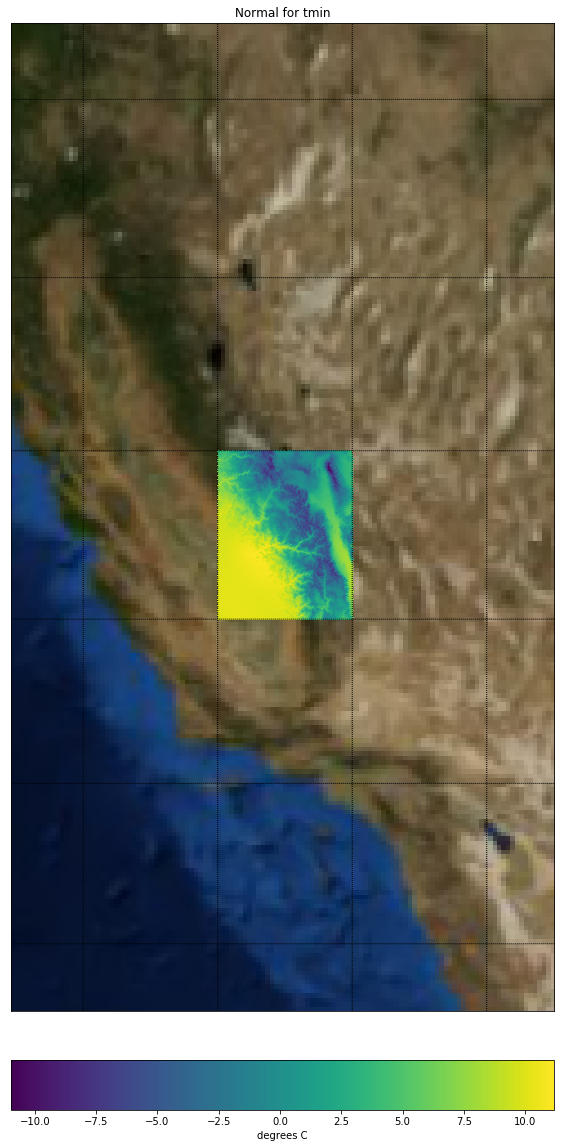

In [35]:
title = "Normal for " + curr_var
plot_tile(normal_data_masked, title)

### 8. Calculating an Anomaly
Now that we have the normalized data over the years 1981 to 2010, let's calculate an anomaly. Say for example we are interested in how the data deviates from the year 1990. Again, we are going to need to get the indices for the subset of data we need.

In [36]:
start_anom_index = dates["01-01-1990"]
end_anom_index   = dates["12-31-1990"]
print(start_anom_index, end_anom_index)

3650 4014


In [37]:
anom_data = data_grid.array[start_anom_index:end_anom_index]

In [38]:
anom_data.shape

(364, 246, 214)

Again, we will need to go through the process of averaging and masking data.

In [39]:
mean_anom_data = np.mean(anom_data, axis=0)

In [40]:
mean_anom_data.shape

(246, 214)

In [41]:
anom_masked = np.ma.masked_where(mean_anom_data < -9000, mean_anom_data)

In [42]:
anom_masked.shape

(246, 214)

An anomaly is a comparison bewteen a subset of the data with the Normal data. In this case, we will simply calculate the difference between the two, but a number of statistics can be used to calculate a comparison.

In [43]:
diff = np.abs(normal_data_masked - anom_masked)

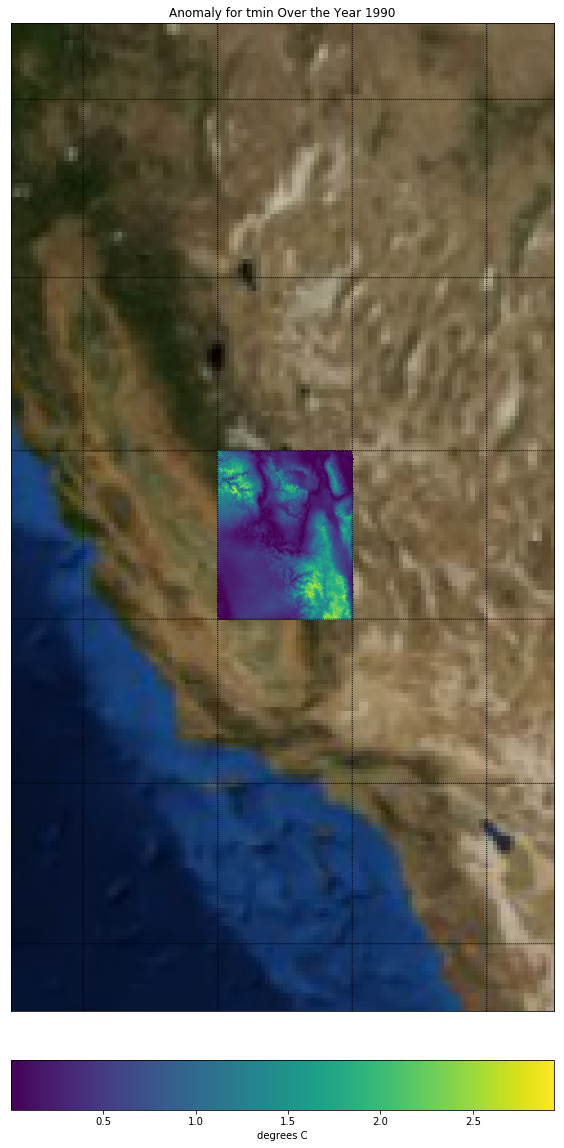

In [44]:
title = "Anomaly for " + curr_var + " Over the Year 1990"
plot_tile(diff, title)

As you can see, this `basemap` shows the absolute difference between 1990 and the Normal for this tile and variable.